## Documentation
### README

It should cover:

**How to set up folders and where each file is saved**
All files are save in a folder after extraction from the downloaded zip file

**Order in which to run code**
The code was written in *Jupyter* notebook, saved as .ipynb

**Explanations of features used**
All the features in the dataset was used for prediction after some EDA
Environment for the code to be run (conda environment.yml file or an environment.txt file)
Hardware needed (e.g. Google Colab or the specifications of your local machine)
Expected run time for each notebook. This will be useful to the review team for time and resource allocation.

In [1]:
#Import important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew

In [2]:
#Write a wangle function for basic EDA
def wrangle(df_path):
    
    #Read the file into a dataframe
    data = pd.read_csv(df_path,low_memory=False)
    
    #Fill in the missing values for both variable types
    for name in data.select_dtypes("number"):
        data[name] = data[name].fillna(value=np.mean(data[name]))
    for name in data.select_dtypes("object"):
        data[name] = data[name].fillna("None")
        
    #collect categorical features into a list
    cat_columns = data.dtypes[data.dtypes == "object"].index.to_list()
    
    #Use label encoder to encode the categorical features
    for c in cat_columns:
        label_encoder = LabelEncoder() 
        label_encoder.fit(list(data[c].values)) 
        data[c] = label_encoder.transform(list(data[c].values))
    return data

In [3]:
#Load the Train dataset and view the first 5 rows
train_df = wrangle('Housing_dataset_train.csv')
train_df.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,19,8,2.000000,2.0,1.000000,1149999.565
1,2748,28,0,4.308171,2.0,4.000000,1672416.689
2,9261,12,6,7.000000,5.0,3.169825,3364799.814
3,2224,3,3,5.000000,2.0,4.000000,2410306.756
4,10300,21,9,4.308171,5.0,6.000000,2600700.898


Skewness: 2.451809
Kurtosis: 15.218322



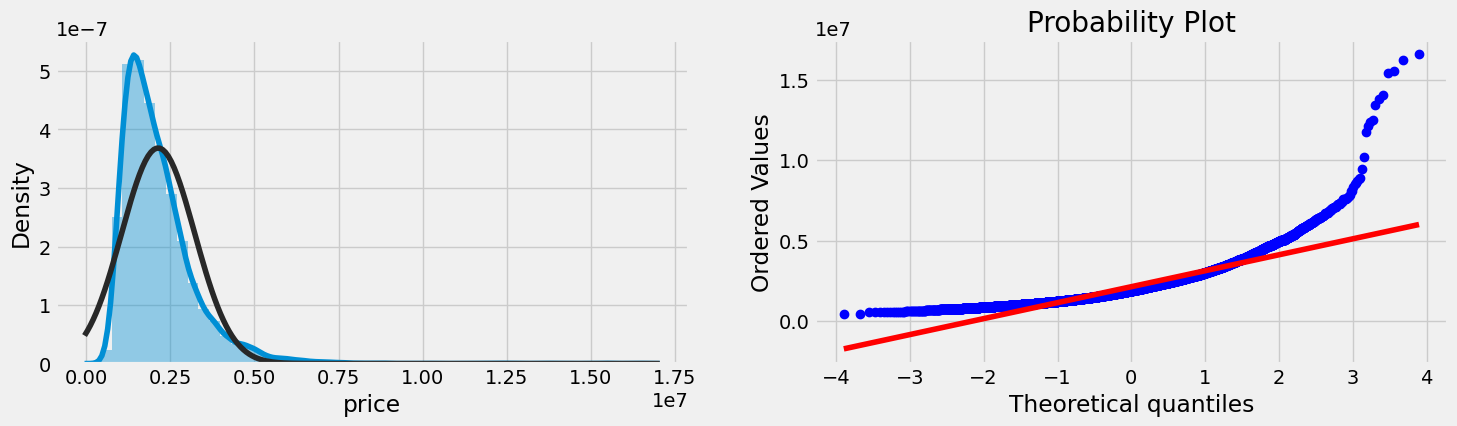

In [4]:
print("Skewness: %f" % train_df['price'].skew())
print("Kurtosis: %f" % train_df['price'].kurt())
print()
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.distplot(train_df['price'] , fit=norm, ax=ax[0])
#Get also the QQ-plot
res = stats.probplot(train_df['price'],plot=ax[1])
plt.show()

In [5]:
#Log transformation
train_df['price'] = np.log(train_df['price'])

Skewness: 0.295598
Kurtosis: 0.045280



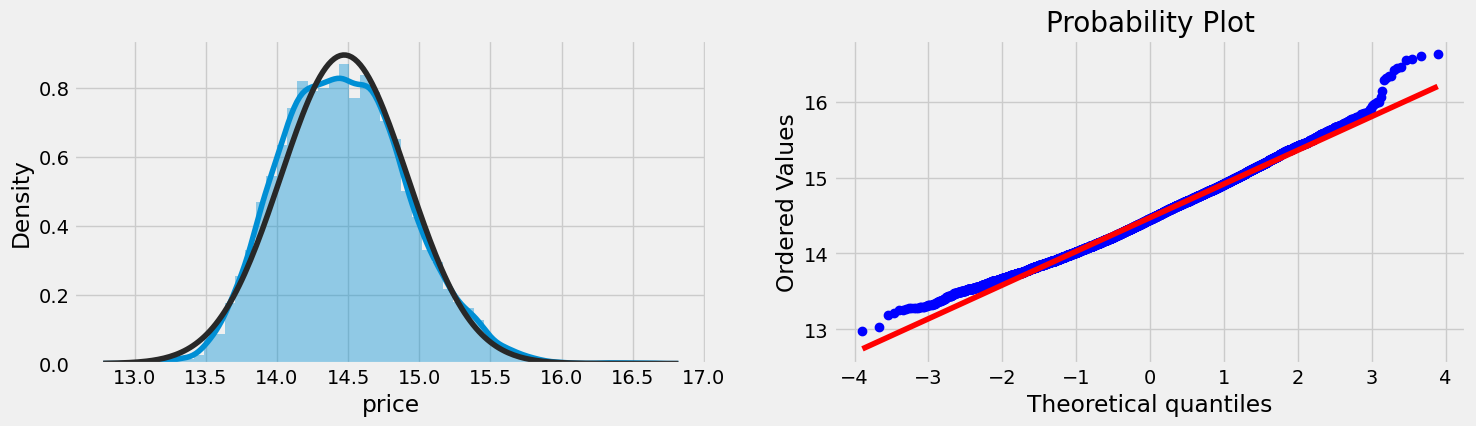

In [6]:
print("Skewness: %f" % train_df['price'].skew())
print("Kurtosis: %f" % train_df['price'].kurt())
print()
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.distplot(train_df['price'] , fit=norm, ax=ax[0])
#Get also the QQ-plot
res = stats.probplot(train_df['price'],plot=ax[1])
plt.show()

In [7]:
#Deriving the summary statistics of the train dataframe after the log transformation of the target columns
train_df.describe()

,ID,loc,title,bedroom,bathroom,parking_space,price
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,4862.700357,18.821571,5.196929,4.308171,3.134235,3.169825,14.471872
std,3818.348214,10.376574,3.118697,2.278917,1.900167,1.492378,0.445117
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.976105
25%,1672.750000,10.000000,3.000000,3.000000,2.000000,2.000000,14.147680
50%,3527.000000,20.000000,5.000000,4.308171,3.000000,3.000000,14.454847
75%,8011.250000,26.000000,8.000000,6.000000,4.000000,4.000000,14.765893
max,12999.000000,36.000000,10.000000,9.000000,7.000000,6.000000,16.623013


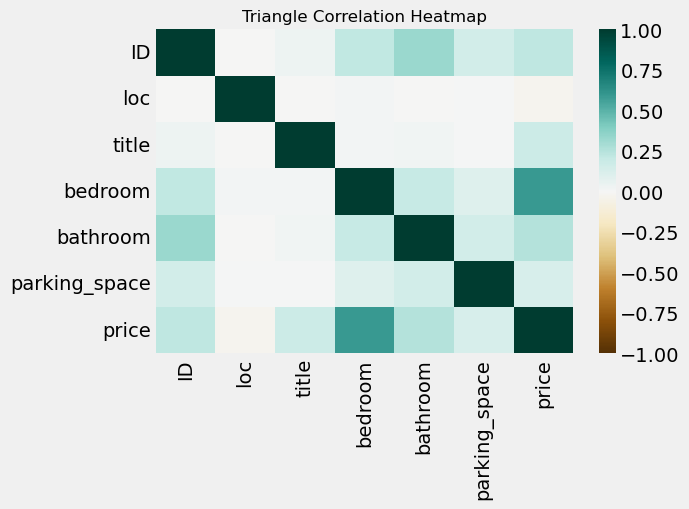

In [8]:
plt.figure(figsize=(6, 4))
# define the mask to set the values in the upper triangle to True
#mask = np.triu(np.ones_like(train_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':12}, pad=6);

In [9]:
# we drop the ID column
ID_train = train_df['ID']
train_df = train_df.drop(columns = 'ID',axis=1)

In [10]:
test_df = wrangle('Housing_dataset_test.csv')
test_df.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,18,6,4,1,2
1,1924,1,0,2,2,4
2,10718,1,1,2,7,2
3,12076,23,5,9,5,2
4,12254,14,7,5,6,1


In [11]:
ID_test = test_df['ID']
test_df = test_df.drop(columns = 'ID',axis=1)

In [12]:
target = "price"
y_train = train_df[target]
X_train = train_df.drop(columns=target,axis=1)
print(X_train.shape,y_train.shape)

(14000, 5) (14000,)


In [13]:
#Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(test_df)

In [14]:
#Test several model, the model with the best R square score is used
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import make_scorer,r2_score
from sklearn.metrics import mean_squared_error


def test_model(model, X_train=X_train, y_train=y_train):
    cv = KFold(n_splits=7,shuffle=True,random_state=42)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model,X_train,y_train,cv=cv,scoring=r2)
    score = [r2_val_score.mean()]
    return score

In [15]:
##Linear Regression
from sklearn.linear_model import LinearRegression, Ridge,Lasso
LR = LinearRegression( n_jobs=-1)
LR.fit(X_train,y_train)
test_model(LR)

[0.39860533667209985]

In [17]:
#Random Forest 
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(random_state = 42)
RF.fit(X_train,y_train)
test_model(RF)

[0.7268123994526565]

In [18]:
#Ridge regression
RidR = Ridge(alpha = 0.5)
RidR.fit(X_train,y_train)
test_model(RidR)

[0.3986053424185775]

In [19]:
#Elastic Net
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
test_model(ENet)

[0.3985968975370919]

In [20]:
#Lasso Regression
LasR = Lasso(alpha = 0.001)
LasR.fit(X_train,y_train)
test_model(LasR)

[0.3985832931429716]

In [21]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor

DTree = DecisionTreeRegressor(max_depth=8)
DTree.fit(X_train,y_train)
test_model(DTree)

[0.642668948735871]

In [22]:
#SVM
from sklearn.svm import SVR
Svm = SVR(kernel='rbf')
test_model(Svm)

[0.5086900941867395]

In [23]:
target = "price"
y_train = train_df[target]
X_train = train_df.drop(columns=target,axis=1)
print(X_train.shape,y_train.shape)

(14000, 5) (14000,)


In [24]:
y_test_pred = pd.Series(RF.predict(X_test))
y_test_pred.head()

0    14.375024
1    13.869209
2    14.138849
3    15.849375
4    14.833415
dtype: float64

In [25]:
pred=np.exp(RF.predict(X_test)).round(2)
pred

array([1749820.59, 1055166.15, 1381732.96, ..., 1758022.21, 1658874.8 ,
       4034988.91])

In [37]:
#check our accuracy score
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_train[:len(y_test_pred)],y_test_pred,squared=False)
error

1.8331988711193639

In [31]:
submit_test = pd.concat([ID_test,pd.DataFrame(pred)],axis=1)
submit_test.columns = ['Id','SalePrice']
submit_test

,Id,SalePrice
0,845,1749820.59
1,1924,1055166.15
2,10718,1381732.96
3,12076,7643568.90
4,12254,2767390.77
...,...,...
5995,1594,1695316.12
5996,2416,2037435.72
5997,10195,1758022.21
5998,9455,1658874.80


In [32]:
submit_test.to_csv('submission.csv', index=False)

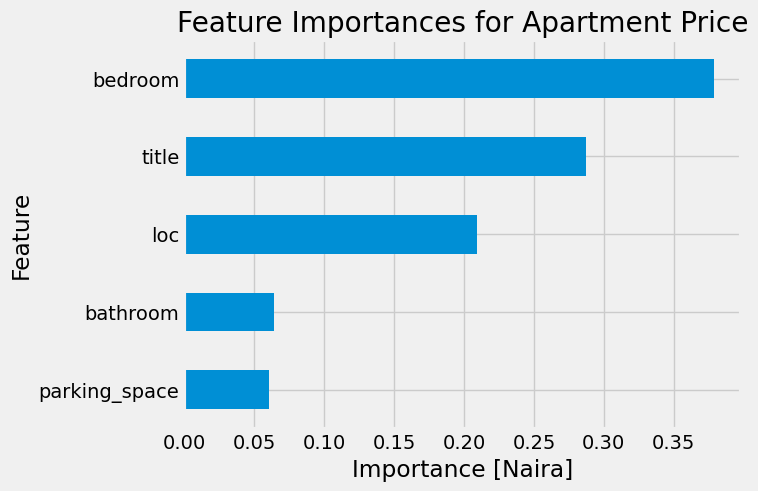

In [35]:
coefficients = RF.feature_importances_
features = X_train.columns
feat_imp = pd.Series(coefficients,index=features).sort_values(key=abs).tail()
# Build bar chart for the 5 most influential coefficients of the model
feat_imp.plot(kind="barh")
# Label axes
plt.xlabel("Importance [Naira]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price");